In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[]


In [12]:
import glob
from PIL import Image
import glob
all_images=[]
all_labels=[]
img_size=(96,96)
for f in glob.glob('d:\\data\\foods\\**\\*.jpg', recursive=True):
    arr=f.split('\\')
    img = Image.open(f)
    img_resize = img.resize((img_size[0], img_size[1]))
    all_images.append(img_resize)
    label=0
    if arr[3]=='Chicken':
        label=0
    elif arr[3]=='Dolsot':
        label=1
    elif arr[3]=='Jeyug':
        label=2
    elif arr[3]=='Kimchi':
        label=3
    elif arr[3]=='Samgyeob':
        label=4
    elif arr[3]=='Soybean':
        label=5
    all_labels.append(label)

In [13]:
import numpy as np
X=np.empty((1,img_size[0],img_size[1],3))
for img in all_images:
    X=np.vstack((X,np.array(img).reshape(1,img_size[0],img_size[1],3)))
X.shape

(179, 96, 96, 3)

In [35]:
X

array([[[[111.,  20.,  10.],
         [174.,  54.,  35.],
         [159.,  55.,  36.],
         ...,
         [ 74.,  63.,  50.],
         [ 76.,  59.,  45.],
         [ 86.,  67.,  52.]],

        [[161.,  25.,   4.],
         [179.,  26.,   1.],
         [160.,  22.,   1.],
         ...,
         [ 80.,  67.,  54.],
         [ 80.,  64.,  48.],
         [ 80.,  60.,  44.]],

        [[175.,  38.,   5.],
         [158.,  17.,   1.],
         [133.,   9.,   2.],
         ...,
         [ 76.,  62.,  51.],
         [ 85.,  71.,  58.],
         [ 84.,  69.,  56.]],

        ...,

        [[184., 157., 139.],
         [171., 140., 126.],
         [185., 147., 126.],
         ...,
         [ 79.,  54.,  39.],
         [ 86.,  56.,  40.],
         [ 69.,  49.,  35.]],

        [[176., 146., 129.],
         [178., 144., 126.],
         [191., 153., 132.],
         ...,
         [ 78.,  55.,  42.],
         [ 83.,  54.,  37.],
         [ 72.,  48.,  34.]],

        [[175., 144., 131.],
       

In [14]:
X = np.delete(X, (0), axis=0)

In [15]:
X.shape

(178, 96, 96, 3)

In [16]:
y=np.array(all_labels)
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

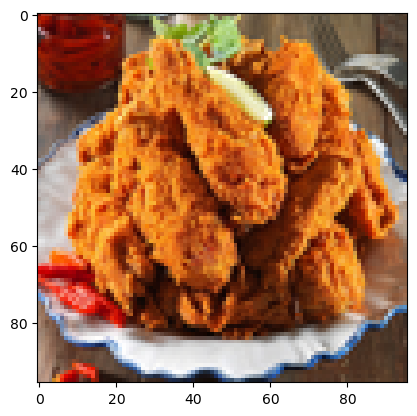

In [17]:
import matplotlib.pyplot as plt
plt.imshow(all_images[0])
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, shuffle=True, 
                                                    random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 96, 96, 3), (36, 96, 96, 3), (142,), (36,))

In [19]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

0    24
1    24
3    24
4    24
5    24
2    22
dtype: int64

In [20]:
X_train=X_train.reshape(-1,img_size[0]*img_size[1]*3)
X_test=X_test.reshape(-1,img_size[0]*img_size[1]*3)

In [21]:
X_train=X_train/255.
X_test=X_test/255.

In [22]:
X_train=X_train.reshape(-1,img_size[0],img_size[1],3)
X_test=X_test.reshape(-1,img_size[0],img_size[1],3)

In [23]:
y_train[:10]

array([3, 5, 5, 5, 2, 0, 5, 2, 1, 2])

In [24]:
from tensorflow.keras import utils
y_train_backup=y_train
y_test_backup=y_test
y_train=utils.to_categorical(y_train,6)
y_test=utils.to_categorical(y_test,6)

In [25]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,Flatten
model=Sequential()
model.add(Conv2D(64,(3,3),padding="same", #입력=출력
                 input_shape=X_train.shape[1:],
                 activation='tanh'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3),activation="tanh"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16,(3,3),activation="tanh"))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(6,activation="softmax"))
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 7056)              0

In [27]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("d:/data/model/food_best.h5",
monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
hist = model.fit(X_train, y_train, batch_size=32,
                 validation_split=0.2, epochs=100, 
                 callbacks=[checkpoint])

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 3.8293 - accuracy: 0.1593
Epoch 1: val_accuracy improved from -inf to 0.24138, saving model to c:/data/model\food_best.h5
4/4 [==============================] - 2s 379ms/step - loss: 3.8293 - accuracy: 0.1593 - val_loss: 2.4387 - val_accuracy: 0.2414
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 4.3178 - accuracy: 0.1239
Epoch 2: val_accuracy did not improve from 0.24138
4/4 [==============================] - 1s 317ms/step - loss: 4.3178 - accuracy: 0.1239 - val_loss: 1.7450 - val_accuracy: 0.1724
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.7495 - accuracy: 0.2478
Epoch 3: val_accuracy did not improve from 0.24138
4/4 [==============================] - 1s 299ms/step - loss: 1.7495 - accuracy: 0.2478 - val_loss: 1.9168 - val_accuracy: 0.0690
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.6610 - accuracy: 0.2743
Epoch 4: val_accuracy did not improve from 

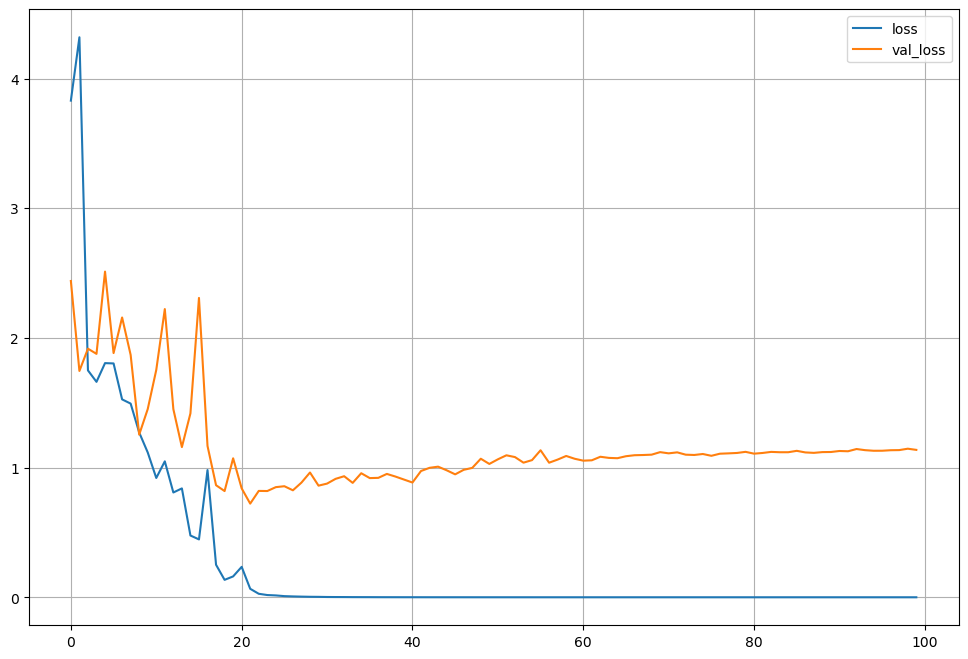

In [28]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

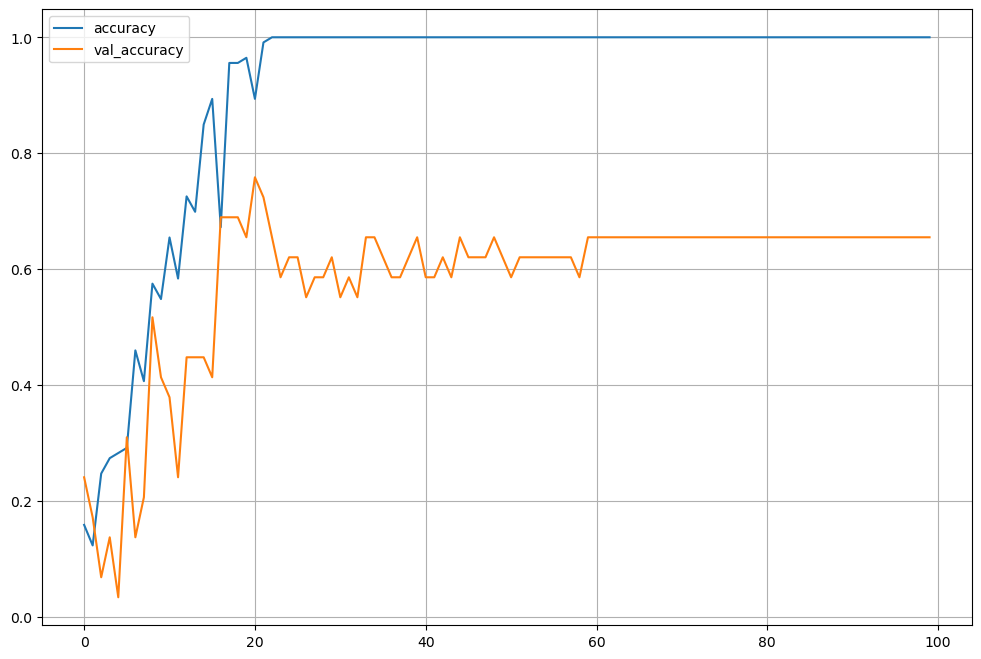

In [29]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.grid()
plt.show()

In [31]:
#학습용
from tensorflow.keras.models import load_model
model = load_model('d:/data/model/food_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

5/5 [==============================] - 0s 58ms/step - loss: 0.2338 - accuracy: 0.9366
[0.23383474349975586, 0.9366196990013123]
accuracy: 93.66%


In [32]:
#검증용
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 8ms/step - loss: 1.4739 - accuracy: 0.3889
[1.47390878200531, 0.3888888955116272]
accuracy: 38.89%


In [33]:
pred=model.predict(X_test)
np.argmax(pred,axis=1)

2/2 [==============================] - 0s 11ms/step


array([2, 2, 5, 2, 2, 4, 4, 3, 3, 5, 1, 4, 1, 5, 2, 5, 5, 4, 5, 5, 4, 4,
       5, 2, 4, 5, 2, 5, 2, 4, 2, 5, 3, 2, 2, 2], dtype=int64)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test_backup, np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.17      0.25         6
           2       0.25      0.50      0.33         6
           3       0.33      0.17      0.22         6
           4       0.75      1.00      0.86         6
           5       0.27      0.50      0.35         6

    accuracy                           0.39        36
   macro avg       0.35      0.39      0.34        36
weighted avg       0.35      0.39      0.34        36



c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
